In [1]:
import datetime
import time
import os
import glob
import sys
sys.path.append('..')
sys.path.append('../src')

# --- Dependencies
import pygmo as pg
import numpy as np
import pandas as pd
import sobol_seq

# import dovpanda

import plotly
from plotly import graph_objs as go
from plotly import tools
import plotly.express as px

from src.ploting import plot_mo

# import re
# import ast
# def str2array(s):
#     # Remove space after [
#     s=re.sub('\[ +', '[', s.strip())
#     # Replace commas and spaces
#     s=re.sub('[,\s]+', ', ', s)
#     return np.array(ast.literal_eval(s))

def make_nd_pop(pro, x, y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = np.array(x)[nd_front]
    nd_y = np.array(y)[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop

def add_metrics(hmapper_df, pg_udp):
    problem = pg.problem(udp)
    feature_col = ['x{}'.format(i+1) for i in range(problem.get_nx())]
    obj_col = ['f{}'.format(i+1) for i in range(problem.get_nobj())]
    
    map_copy = hmapper_df.copy()
    map_copy['index'] = map_copy['index'] + 1
    map_copy.rename(columns={"index": "i_fevals"}, inplace=True)
    
    obj = [i.tolist() for i in map_copy[obj_col].values]
    param = [i.tolist() for i in map_copy[feature_col].values]
    
    
    p_dist = []
    hypervolume = []
    ndf_size = []
    for i in range(len(map_copy)):
        if i < 2:
            p_dist.append(None)
            hypervolume.append(0)
            ndf_size.append(0)
            
        else:
            nd_pop = make_nd_pop(pro, param[:i+1], obj[:i+1])
#             p_dist.append(None)
            p_distance = pg_udp.p_distance(nd_pop) if hasattr(pg_udp, 'p_distance') else None
            p_dist.append(p_distance) #1. p_distance
            
            ref_point = np.amax(np.array(obj), axis=0).tolist() #2. hypervolume
            hypervolume.append(pg.hypervolume(nd_pop.get_f()
                                         ).compute(ref_point))
            
            ndf_size.append(len(nd_pop.get_f()))
            
    map_copy['p_distance'] = p_dist
    map_copy['hypervolume'] = hypervolume
    map_copy['ndf_size'] = ndf_size
    
    t_stamp = map_copy.Timestamp
    map_copy["i_time"] = t_stamp - t_stamp.shift(periods=1, fill_value=t_stamp.values[0])
    
    return map_copy

In [3]:
DIM = 3
ID = 1
OBJ = 2

# udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)  # == WFG
# udp = pg.zdt(prob_id=ID, param=DIM) # == ZDT
udp = pg.dtlz(prob_id=ID, dim=DIM, fdim=OBJ) # == DTLZ
pro = pg.problem(udp)


name()
df = pd.read_csv('{}'.format(pro.get_name())

# problem = "{}_*.csv".format(pro.get_name())
# folder = './data/hypermapper/all_5x/'
# paths = [i for i in glob.glob('{}{}'.format(folder, problem))]

# group = []
# for p in paths:
#     temp_df = add_metrics(pd.read_csv(p).reset_index(level=0), udp)
#     init_size = np.count_nonzero(temp_df.Timestamp < 900)
#     temp_df['init_size'] = init_size
#     temp_df.init_size = temp_df.init_size.replace(11, 10)
#     temp_df.init_size = temp_df.init_size.replace(251, 250)
#     temp_df.init_size = temp_df.init_size.replace(751, 750)
#     temp_df['problem'] = pro.get_name()
    
#     idx = p.find(problem)+len(problem)+1
#     group_id = p[idx:idx+7]
#     temp_df['group_id'] = group_id
#     group.append(temp_df)
    
# mapr_concat = pd.concat(group)
# mapr_concat
# name = '{}_{}{}_{}.csv'.format(pro.get_name(), 
#                                pro.get_nx(),
#                                pro.get_nobj(),
#                                len(mapr_concat))
# mapr_concat

SyntaxError: unexpected EOF while parsing (<ipython-input-3-8e7c84411646>, line 37)

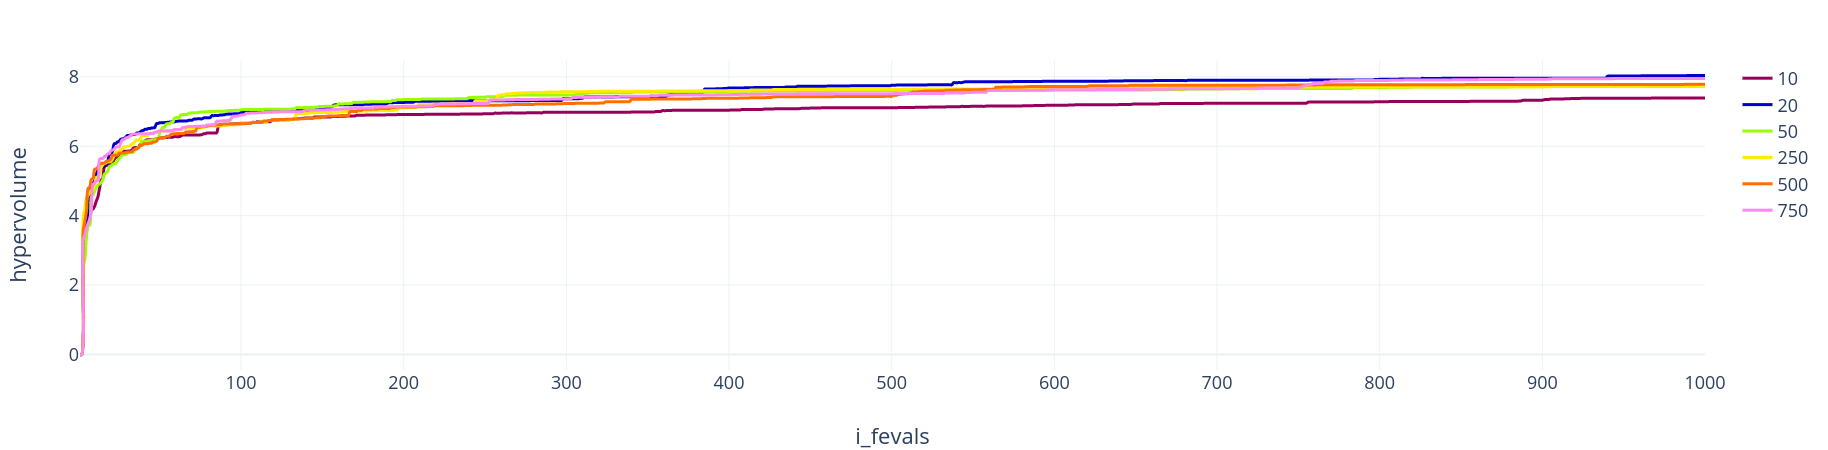

In [149]:
# df.groupby(['i_fevals', 'init_size']).mean().reset_index()
temp_df = df.copy()
temp_df.init_size = temp_df.init_size.replace(11, 10)
temp_df.init_size = temp_df.init_size.replace(251, 250)

# temp_df.init_size = temp_df.init_size.replace(751, 750)

temp_df = temp_df.groupby(['i_fevals', 'init_size']).mean().reset_index()
start_plot = px.line(temp_df,  
            x="i_fevals", 
            y="hypervolume", 
            color="init_size", 
            hover_name="i_time", 
            color_discrete_sequence=['rgb(150,0,90)', 'rgb(0,0,200)',  'rgb(151,255,0)', 'rgb(255,234,0)', 'rgb(255,111,0)', '#fe88ec'],
            template="presentation+plotly_white",
            line_shape="spline", 
            render_mode="svg")
start_plot

In [150]:
# start_plot.write_image("./plots/hypermapper/start_set_{}_x5_average.{}.svg".format(pro.get_name(), len(temp_df)), width=800)

____
____

In [110]:
problem = "*_*.csv"
folder = './data/hypermapper/sampling_plan/concat/'
paths = [i for i in glob.glob('{}{}'.format(folder, problem))]

group = []
for p in paths:
    temp_df = pd.read_csv(p)
    group.append(temp_df)
    
all_experimrnts = pd.concat(group)
all_experimrnts.init_size = all_experimrnts.init_size.replace(11, 10)
all_experimrnts.init_size = all_experimrnts.init_size.replace(251, 250)
all_experimrnts.init_size = all_experimrnts.init_size.replace(751, 750)

In [114]:
all_experimrnts.query('i_fevals==1000')

,i_fevals,f1,f2,x1,x2,Timestamp,p_distance,hypervolume,ndf_size,i_time,init_size,problem,group_id,x3
999,1000,2.019006,0.050535,0.000943,1.578796,5665122,NaN,8.277228,54,6508,20,WFG4,ermappe,NaN
1999,1000,2.005227,0.005227,2.000000,1.489591,5717429,NaN,7.416419,19,6519,10,WFG4,ermappe,NaN
2999,1000,0.023896,4.008236,0.783970,1.656747,4507992,NaN,7.940080,62,11729,500,WFG4,ermappe,NaN
3999,1000,0.075089,4.001596,0.585047,1.568862,5674545,NaN,7.858730,34,6360,10,WFG4,ermappe,NaN
4999,1000,1.309800,3.663490,0.368034,0.621065,5593990,NaN,7.590349,30,656,10,WFG4,ermappe,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25999,1000,0.285149,9.017117,0.083849,0.632490,4347492,0.430422,6.256484,71,6463,250,ZDT6,ermappe,NaN
26999,1000,0.282987,8.174756,0.083157,0.406093,2982695,0.856292,5.679174,52,6505,500,ZDT6,ermappe,NaN
27999,1000,0.281252,9.774138,0.080670,0.906668,3054086,1.019089,6.132246,41,6581,500,ZDT6,ermappe,NaN
28999,1000,0.999223,0.895930,0.313021,0.000013,2234517,1.837716,5.900151,23,9930,750,ZDT6,ermappe,NaN


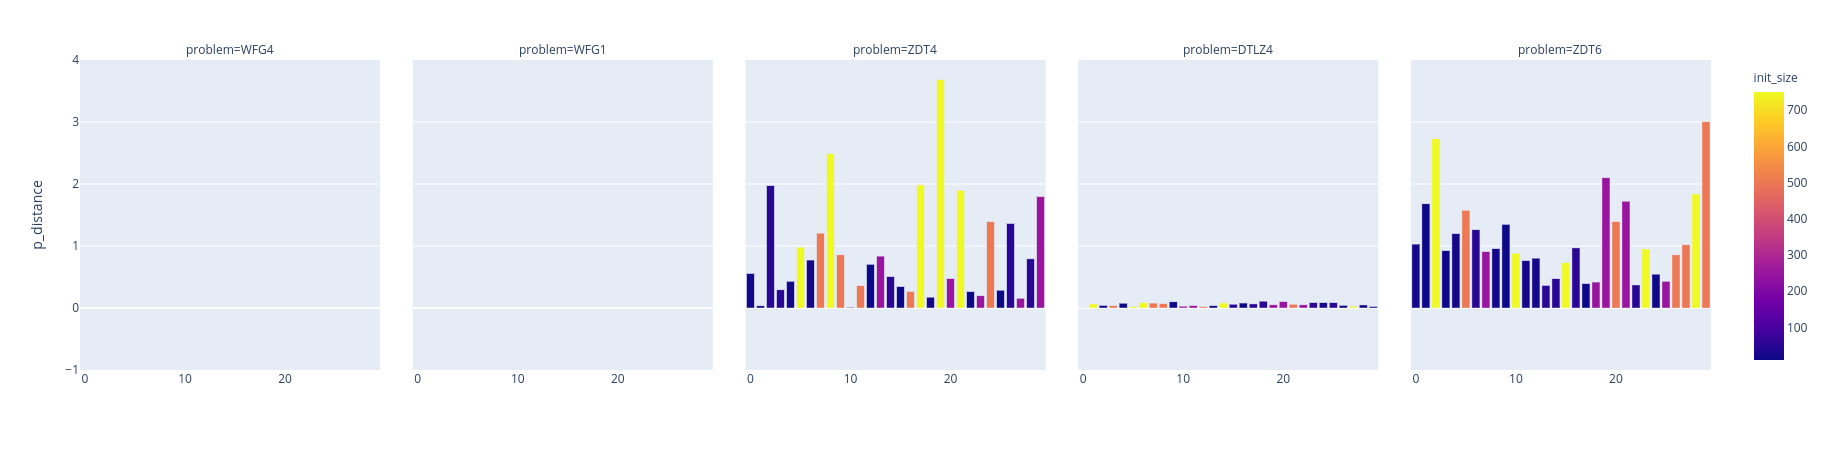

In [117]:
px.bar(all_experimrnts.query('i_fevals==1000'), 
       y="p_distance", 
       color="init_size", 
       color_discrete_sequence=['rgb(150,0,90)', 'rgb(0,0,200)',  'rgb(151,255,0)', 'rgb(255,234,0)', 'rgb(255,111,0)', '#fe88ec'],
       barmode="group", facet_col="problem")

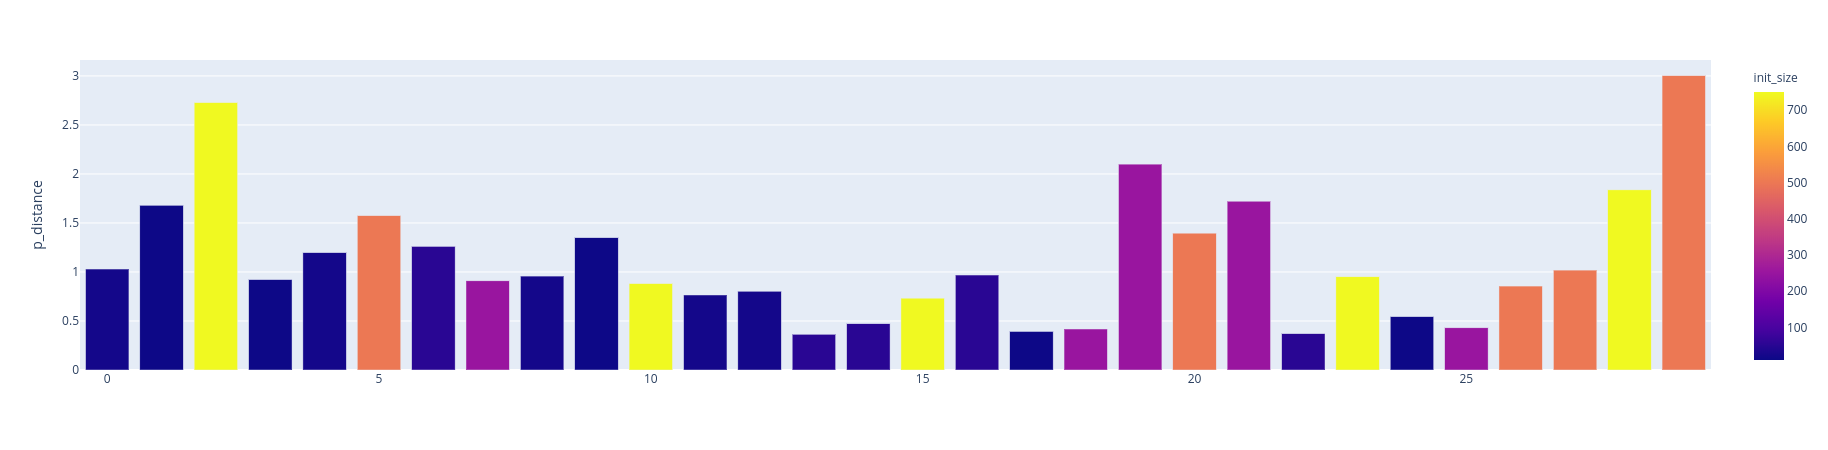

In [138]:

px.bar(all_experimrnts.query('i_fevals==1000 and problem=="ZDT6"'), y="p_distance", color="init_size", hover_data=df.columns)

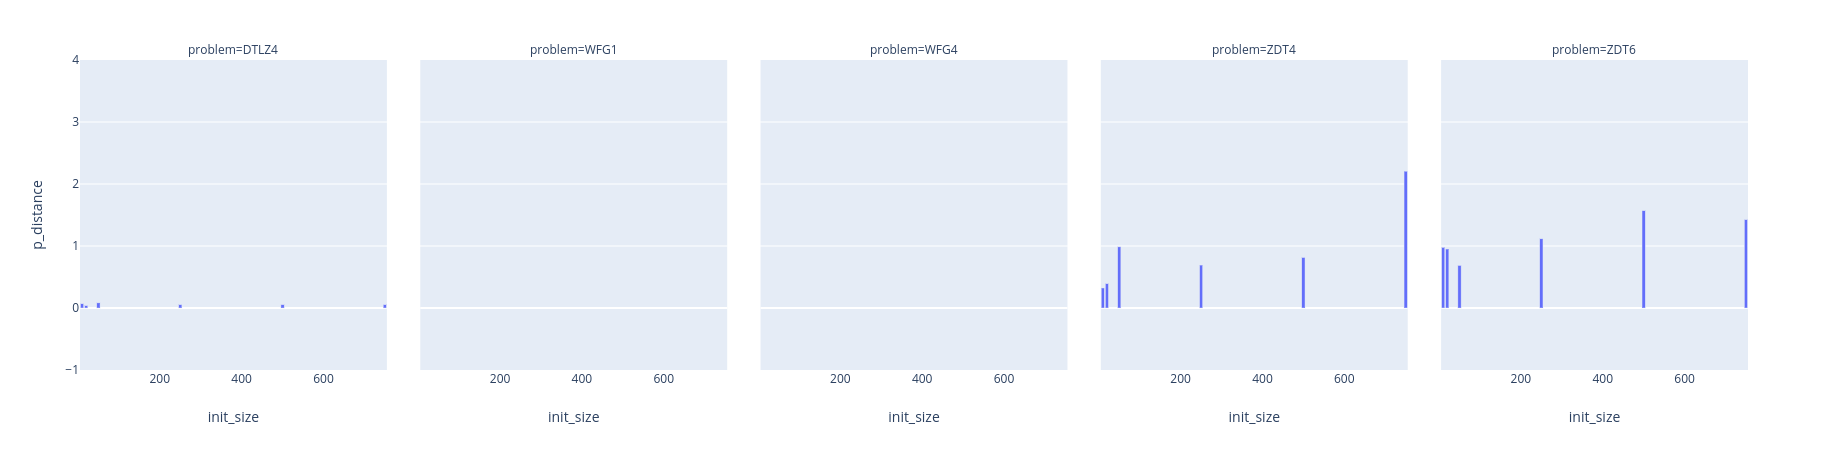

In [131]:
temp_df = all_experimrnts.query('i_fevals==1000').groupby(['problem', 'init_size']).mean().reset_index()
temp_df
px.bar(temp_df, x="init_size", y="p_distance", facet_col="problem", barmode="group")

In [ ]:
fig = go.Figure()
fig.update_layout(template='presentation+plotly_white',
                    title=pro.get_name(),
                    xaxis_title="f evaluations",
                    yaxis_title="p distance",)
fig.add_trace(go.Scatter(x=tut_ndf.i_fevals.values, y=tut_ndf.p_distance.values,
#                     marker_color='rgba(85,85,85,0.6)',
                    mode='markers+lines',
                    name='Tutorm Non-dominated'))
fig.add_trace(go.Scatter(x=tut_stack.i_fevals.values, y=tut_stack.p_distance.values,
#                          marker_color='rgba(51,51,255,1)',
                    mode='markers+lines',
                    name='Tuturm Stack'))

fig.add_trace(go.Scatter(x=df_metr[100:].index.values, y=df_metr[100:].p_distance.values,
                    marker_color='rgba(85,85,85,0.6)',
                    mode='lines',
                    name='Hypermapper'))

temp = nsga2_zdt4.copy()
temp['i_fevals'] = temp['i_fevals'].apply(lambda x: x - 100)
temp = temp.query('i_fevals<=2000')
fig.add_trace(go.Scatter(x=temp.i_fevals.values, y=temp.p_distance.values,
                    line=dict(color='green',
                              dash='dash'),
                    mode='markers+lines',
                    name='NSGA2'))


fig.show()

In [3]:
name = '{}_{}{}*.csv'.format(pro.get_name(), pro.get_nx(), pro.get_nobj())
folder = './data/hypermapper/concat/'
paths = glob.glob('{}{}'.format(folder, name))
df_map = pd.read_csv(paths[0])
df_map

NameError: name 'pro' is not defined